# **Import Libraries**

In [1]:
import pandas as pd
import cv2
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, SeparableConv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout,Flatten
import os
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
import seaborn as sns
from sklearn.metrics import confusion_matrix ,classification_report
from tensorflow.keras import layers, models
from tensorflow.keras import regularizers
from tensorflow.keras.applications import VGG16
from collections import Counter
from tensorflow.keras.layers import GaussianNoise, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

import warnings
warnings.filterwarnings('ignore')

# **Read Training and Testig Data**

In [2]:
train_dir = "../input/fer2013/train" 
test_dir = "../input/fer2013/test" 

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)

# Initialize only rescale for test data
test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [4]:
train_generator = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    subset="training"
)


validation_generator = train_datagen.flow_from_directory(
    directory=train_dir, 
    target_size=(48, 48),
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    subset="validation"  
)


test_data = test_datagen.flow_from_directory(
    test_dir,  
    target_size=(48, 48),
    batch_size=64,
    class_mode="categorical",
    shuffle=True
)

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


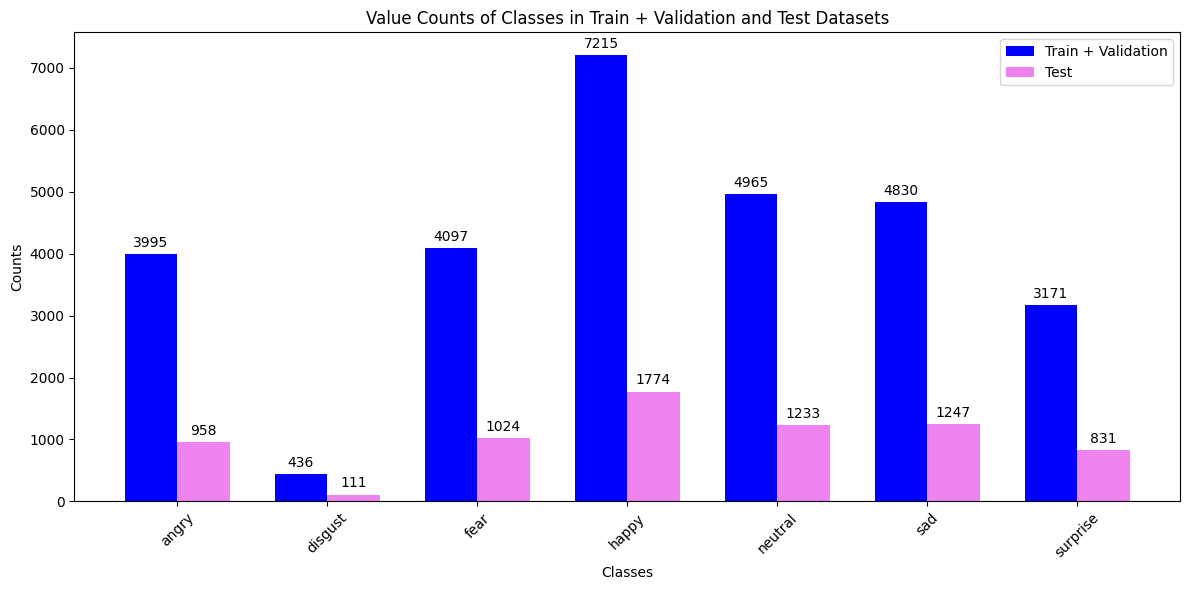

In [6]:
train_class_indices = train_generator.class_indices
test_class_indices = test_data.class_indices

train_labels = {v: k for k, v in train_class_indices.items()}
test_labels = {v: k for k, v in test_class_indices.items()}


train_validation_counts = np.zeros(len(train_class_indices))
test_counts = np.zeros(len(test_class_indices))

for i, label in enumerate(train_generator.classes):
    train_validation_counts[label] += 1

for i, label in enumerate(validation_generator.classes):
    train_validation_counts[label] += 1

for i, label in enumerate(test_data.classes):
    test_counts[label] += 1

# Plotting the bar chart
labels = list(train_class_indices.keys())
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width/2, train_validation_counts, width, label='Train + Validation', color='blue')
bars2 = ax.bar(x + width/2, test_counts, width, label='Test',color='violet')


ax.set_xlabel('Classes')
ax.set_ylabel('Counts')
ax.set_title('Value Counts of Classes in Train + Validation and Test Datasets')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45)
ax.legend()


def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate('{}'.format(int(height)),
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_labels(bars1)
add_labels(bars2)

fig.tight_layout()

plt.show()

# **Train A Custom CNN Model**

In [7]:
CNN = Sequential()

CNN.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 3), padding='same'))
CNN.add(BatchNormalization())

CNN.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
CNN.add(BatchNormalization())
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Dropout(0.2))

CNN.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
CNN.add(BatchNormalization())

CNN.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
CNN.add(BatchNormalization())
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Dropout(0.2))

CNN.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
CNN.add(BatchNormalization())

CNN.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
CNN.add(BatchNormalization())
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Dropout(0.2))

CNN.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
CNN.add(BatchNormalization())
CNN.add(MaxPooling2D(pool_size=(2, 2)))
CNN.add(Dropout(0.2))

CNN.add(Flatten())
CNN.add(Dense(512, activation='relu'))
CNN.add(BatchNormalization())
CNN.add(Dropout(0.4))
CNN.add(Dense(256, activation='relu'))
CNN.add(BatchNormalization())
CNN.add(Dropout(0.4))
CNN.add(Dense(7, activation='softmax'))

In [8]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
]
CNN.compile(
    loss="categorical_crossentropy", 
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    metrics = METRICS
)

CNN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 4,807,751 (18.34 MB)

 Trainable params: 4,803,463 (18.32 MB)

 Non-trainable params: 4,288 (16.75 KB)

In [9]:
checkpoint_callback = ModelCheckpoint(
    filepath='CNN_aug.weights.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=True,
    mode='max',
    verbose=1
)



early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)

history = CNN.fit(
    train_generator, 
    validation_data=validation_generator, 
    epochs=50, 
    callbacks=[early_stopping, checkpoint_callback,reduce_lr]
)

Epoch 1/50


2024-06-27 05:04:44.487251: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2304: 4.34183, expected 3.61488
2024-06-27 05:04:44.487335: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2305: 5.83686, expected 5.1099
2024-06-27 05:04:44.487350: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2306: 4.82442, expected 4.09746
2024-06-27 05:04:44.487363: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2307: 4.63712, expected 3.91017
2024-06-27 05:04:44.487376: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2308: 4.36758, expected 3.64062
2024-06-27 05:04:44.487395: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2309: 5.45394, expected 4.72698
2024-06-27 05:04:44.487407: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2310: 5.20225, expected 4.47529
2024-06-27 05:04:44.487418: E exter

  1/359 ━━━━━━━━━━━━━━━━━━━━ 3:14:19 33s/step - accuracy: 0.7969 - auc: 0.4915 - loss: 3.2177 - precision: 0.1351 - recall: 0.0781

I0000 00:00:1719464698.231526     127 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719464698.266561     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


234/359 ━━━━━━━━━━━━━━━━━━━━ 53s 425ms/step - accuracy: 0.8255 - auc: 0.5562 - loss: 2.5033 - precision: 0.1896 - recall: 0.0666

2024-06-27 05:06:46.107692: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.14482, expected 3.5284
2024-06-27 05:06:46.107773: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.00406, expected 4.38764
2024-06-27 05:06:46.107784: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.11799, expected 3.50157
2024-06-27 05:06:46.107792: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.39047, expected 3.77405
2024-06-27 05:06:46.107801: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 3.50993, expected 2.89351
2024-06-27 05:06:46.107810: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 3.25155, expected 2.63512
2024-06-27 05:06:46.107818: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 10: 3.87865, expected 3.26222
2024-06-27 05:06:46.107827: E external/local_xla/xla/se

357/359 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step - accuracy: 0.8295 - auc: 0.5686 - loss: 2.4047 - precision: 0.1947 - recall: 0.0603

W0000 00:00:1719464871.386455     127 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
2024-06-27 05:08:28.621898: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 4.35124, expected 3.6494
2024-06-27 05:08:28.621970: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 5.77578, expected 5.07394
2024-06-27 05:08:28.621981: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 5.17148, expected 4.46964
2024-06-27 05:08:28.621990: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.77571, expected 4.07386
2024-06-27 05:08:28.621999: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.68603, expected 3.98419
2024-06-27 05:08:28.622007: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.32295, expected 4.62111
2024-06-27 05:08:28.622016: E external/local_xla/xla/service/gpu/b


Epoch 1: val_accuracy improved from -inf to 0.85714, saving model to CNN_aug.weights.h5
359/359 ━━━━━━━━━━━━━━━━━━━━ 245s 594ms/step - accuracy: 0.8296 - auc: 0.5689 - loss: 2.4028 - precision: 0.1949 - recall: 0.0601 - val_accuracy: 0.8571 - val_auc: 0.6365 - val_loss: 1.8454 - val_precision: 0.0000e+00 - val_recall: 0.0000e+00 - learning_rate: 0.0010
Epoch 2/50
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.8519 - auc: 0.6595 - loss: 1.8782 - precision: 0.2857 - recall: 0.0245
Epoch 2: val_accuracy did not improve from 0.85714
359/359 ━━━━━━━━━━━━━━━━━━━━ 63s 172ms/step - accuracy: 0.8519 - auc: 0.6595 - loss: 1.8780 - precision: 0.2859 - recall: 0.0245 - val_accuracy: 0.8545 - val_auc: 0.6937 - val_loss: 1.7654 - val_precision: 0.4321 - val_recall: 0.0587 - learning_rate: 0.0010
Epoch 3/50
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.8565 - auc: 0.7042 - loss: 1.7476 - precision: 0.4764 - recall: 0.0512
Epoch 3: val_accuracy improved from 0.85714 to 0.85966, s

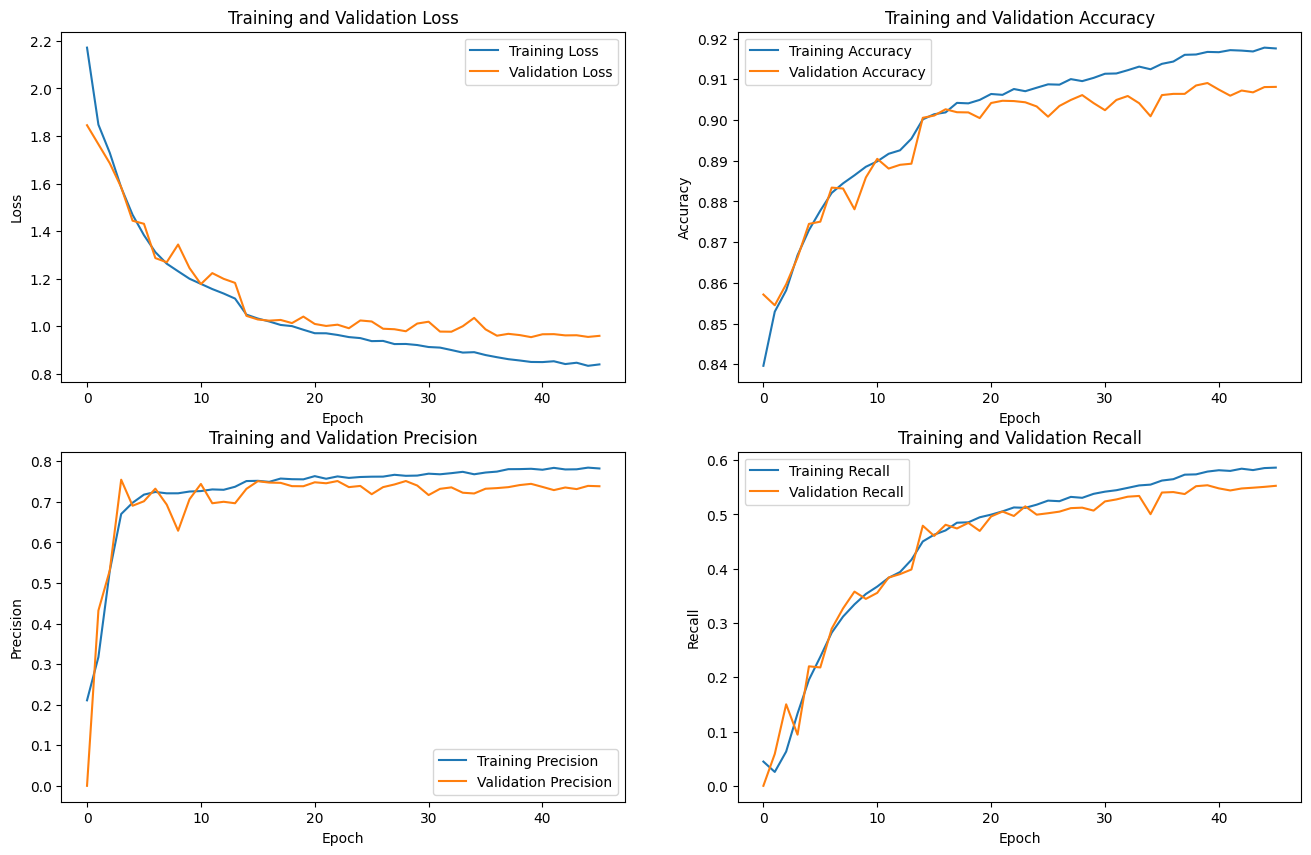

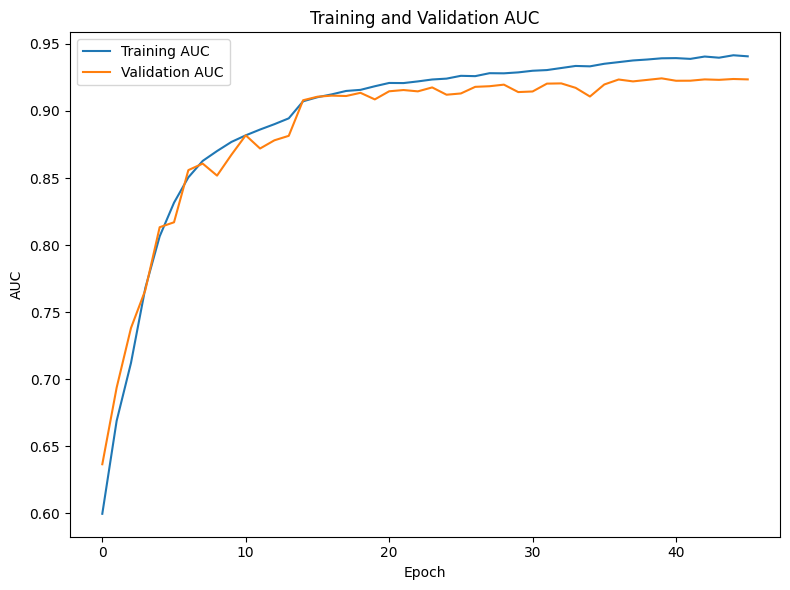

In [11]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
training_precision = history.history['precision']
validation_precision = history.history['val_precision']
training_recall = history.history['recall']
validation_recall = history.history['val_recall']
training_auc = history.history['auc']
validation_auc = history.history['val_auc']

# Plotting the loss and accuracy
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the precision
plt.subplot(2, 2, 3)
plt.plot(training_precision, label='Training Precision')
plt.plot(validation_precision, label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plotting the recall
plt.subplot(2, 2, 4)
plt.plot(training_recall, label='Training Recall')
plt.plot(validation_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# Plotting the AUC
plt.figure(figsize=(8, 6))
plt.plot(training_auc, label='Training AUC')
plt.plot(validation_auc, label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
CNN.save('cnn.h5')

# **Evaluation The CNN Model**

  4/113 ━━━━━━━━━━━━━━━━━━━━ 5s 53ms/step

W0000 00:00:1719467683.004813     129 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 8s 64ms/step


W0000 00:00:1719467690.159825     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


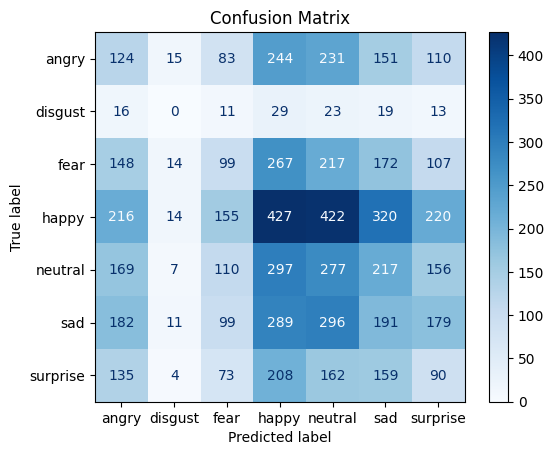

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
test_data.reset()  
predictions = CNN.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data.classes


cm = confusion_matrix(true_classes, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [14]:
classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
report = classification_report(true_classes, predicted_classes, target_names=classes)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       Angry       0.13      0.13      0.13       958
     Disgust       0.00      0.00      0.00       111
        Fear       0.16      0.10      0.12      1024
       Happy       0.24      0.24      0.24      1774
     Neutral       0.17      0.22      0.19      1233
         Sad       0.16      0.15      0.15      1247
    Surprise       0.10      0.11      0.11       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.17      0.17      7178



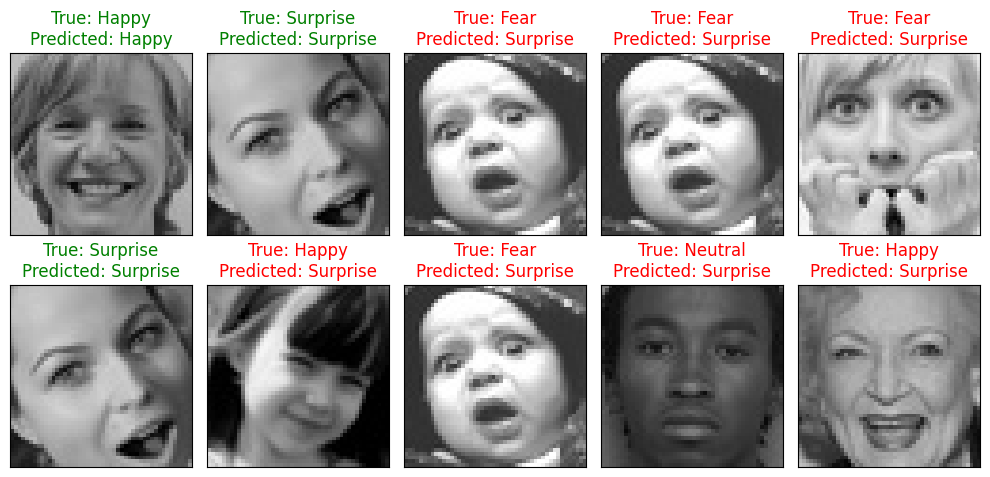

In [38]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_data.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_data) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_data[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_data[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(CNN.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

# **Switch To Transfer Learning and VGG16**

In [24]:
# VGG16

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(48, 48, 3))
base_model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
for layer in base_model.layers[:5]:
    layer.trainable = False

In [26]:
inputs = Input(shape=(48, 48, 3))

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)

# Create the model
model = Model(inputs=base_model.input, outputs=output)

# Show the model summary
model.summary()

Model: "functional_31"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 48, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 48, 48, 64)     │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 48, 48, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 24, 24, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 6, 6, 512)      │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 3, 3, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 1, 1, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,32

 Total params: 15,146,055 (57.78 MB)

 Trainable params: 15,031,687 (57.34 MB)

 Non-trainable params: 114,368 (446.75 KB)

In [27]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
]
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

model.compile(optimizer=adam, loss='categorical_crossentropy',metrics=METRICS)

In [28]:

counter = Counter(train_generator.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : round(max_val/num_images,2) for class_id, num_images in counter.items()}  

lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 10,verbose = 1,factor = 0.50, min_lr = 1e-10)
mcp = ModelCheckpoint('model.keras')
es = EarlyStopping(verbose=1, patience=20)

history=model.fit(train_generator,
                  validation_data=validation_generator,
                  epochs = 100,
                  verbose =1,
                  callbacks = [lrd,mcp,es], 
                  class_weight = class_weights)

Epoch 1/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 87s 195ms/step - accuracy: 0.8277 - auc: 0.5051 - loss: 4.7052 - precision: 0.1593 - recall: 0.0482 - val_accuracy: 0.7914 - val_auc: 0.4826 - val_loss: 2.4142 - val_precision: 0.1314 - val_recall: 0.0820 - learning_rate: 0.0010
Epoch 2/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 54s 148ms/step - accuracy: 0.8495 - auc: 0.5241 - loss: 3.7314 - precision: 0.1554 - recall: 0.0120 - val_accuracy: 0.8570 - val_auc: 0.5265 - val_loss: 2.0942 - val_precision: 0.4255 - val_recall: 0.0035 - learning_rate: 0.0010
Epoch 3/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 57s 155ms/step - accuracy: 0.8543 - auc: 0.5530 - loss: 3.5204 - precision: 0.1522 - recall: 0.0045 - val_accuracy: 0.7459 - val_auc: 0.4779 - val_loss: 7.3256 - val_precision: 0.1105 - val_recall: 0.1104 - learning_rate: 0.0010
Epoch 4/100
359/359 ━━━━━━━━━━━━━━━━━━━━ 58s 160ms/step - accuracy: 0.8559 - auc: 0.5960 - loss: 3.3991 - precision: 0.3859 - recall: 0.0156 - val_accuracy: 0.8000 - val_auc: 0.5222 - val_lo

# **Evaluation The VGG16 Model**

113/113 ━━━━━━━━━━━━━━━━━━━━ 15s 125ms/step


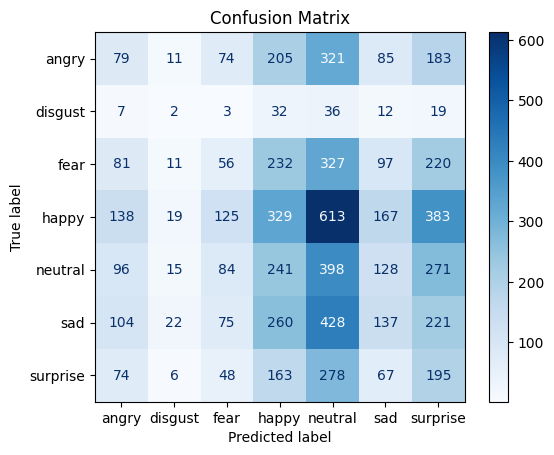

In [29]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
test_data.reset()  
predictions = model.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data.classes


cm = confusion_matrix(true_classes, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

In [30]:
classes=['Angry','Disgust','Fear','Happy','Neutral','Sad','Surprise']
report = classification_report(true_classes, predicted_classes, target_names=classes)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       Angry       0.14      0.08      0.10       958
     Disgust       0.02      0.02      0.02       111
        Fear       0.12      0.05      0.08      1024
       Happy       0.23      0.19      0.20      1774
     Neutral       0.17      0.32      0.22      1233
         Sad       0.20      0.11      0.14      1247
    Surprise       0.13      0.23      0.17       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.13      7178
weighted avg       0.17      0.17      0.16      7178



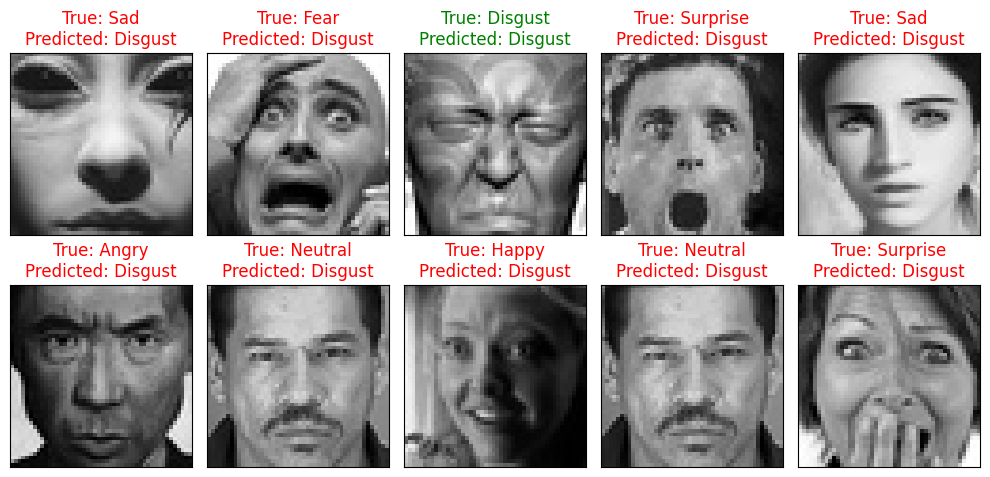

In [40]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_data.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_data) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_data[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_data[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

# **Switch To Transfer Learning and ResNet50**

In [5]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(48, 48, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
output = Dense(7, activation='softmax')(x)

# Create the new model
model_resnet = Model(inputs=base_model.input, outputs=output)

# Summary of the model
model_resnet.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 48, 48, 3) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 54, 54, 3) │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 24, 24,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 24, 24,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 24, 24,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 26, 26,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 12, 12,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 12, 12,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 12, 12,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 12, 12,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 12, 12,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 12, 12,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 12, 12,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 12, 12,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 12, 12,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 12, 12,    │      1,024 │ conv2_block1_3_c

 Total params: 24,805,511 (94.63 MB)

 Trainable params: 24,750,599 (94.42 MB)

 Non-trainable params: 54,912 (214.50 KB)

In [12]:
from tensorflow.keras.optimizers import Adam
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
]
callbacks = [ModelCheckpoint('model.keras',monitor="val_accuracy", verbose=1, save_best_only=True),
            ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=20, verbose=1, min_lr=1e-6),

            EarlyStopping(monitor='val_accuracy', restore_best_weights=True, patience=100)]
model_resnet.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=METRICS)

history_resnet = model_resnet.fit(train_generator,
                  validation_data=validation_generator, epochs=100,  callbacks=callbacks)

Epoch 1/100
  2/359 ━━━━━━━━━━━━━━━━━━━━ 22s 63ms/step - accuracy: 0.7919 - auc: 0.4795 - loss: 3.4158 - precision: 0.1076 - recall: 0.0625   

I0000 00:00:1719479716.341082     133 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1719479716.436735     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 49/359 ━━━━━━━━━━━━━━━━━━━━ 5:09 997ms/step - accuracy: 0.7992 - auc: 0.5000 - loss: 3.1846 - precision: 0.1307 - recall: 0.0715

W0000 00:00:1719479764.196916     133 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step - accuracy: 0.8069 - auc: 0.5179 - loss: 3.0019 - precision: 0.1569 - recall: 0.0800

W0000 00:00:1719479870.516614     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.76189, saving model to model.keras


W0000 00:00:1719479903.913477     132 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


359/359 ━━━━━━━━━━━━━━━━━━━━ 261s 529ms/step - accuracy: 0.8069 - auc: 0.5179 - loss: 3.0015 - precision: 0.1569 - recall: 0.0800 - val_accuracy: 0.7619 - val_auc: 0.5177 - val_loss: 40.1242 - val_precision: 0.1664 - val_recall: 0.1663 - learning_rate: 1.0000e-04
Epoch 2/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8325 - auc: 0.5723 - loss: 2.4875 - precision: 0.2483 - recall: 0.0846
Epoch 2: val_accuracy improved from 0.76189 to 0.84149, saving model to model.keras
359/359 ━━━━━━━━━━━━━━━━━━━━ 56s 152ms/step - accuracy: 0.8326 - auc: 0.5724 - loss: 2.4870 - precision: 0.2485 - recall: 0.0847 - val_accuracy: 0.8415 - val_auc: 0.5886 - val_loss: 3.7495 - val_precision: 0.2263 - val_recall: 0.0453 - learning_rate: 1.0000e-04
Epoch 3/100
358/359 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.8491 - auc: 0.6310 - loss: 2.1445 - precision: 0.3933 - recall: 0.1022
Epoch 3: val_accuracy improved from 0.84149 to 0.86558, saving model to model.keras
359/359 ━━━━━━━━━━━━━━━━━━

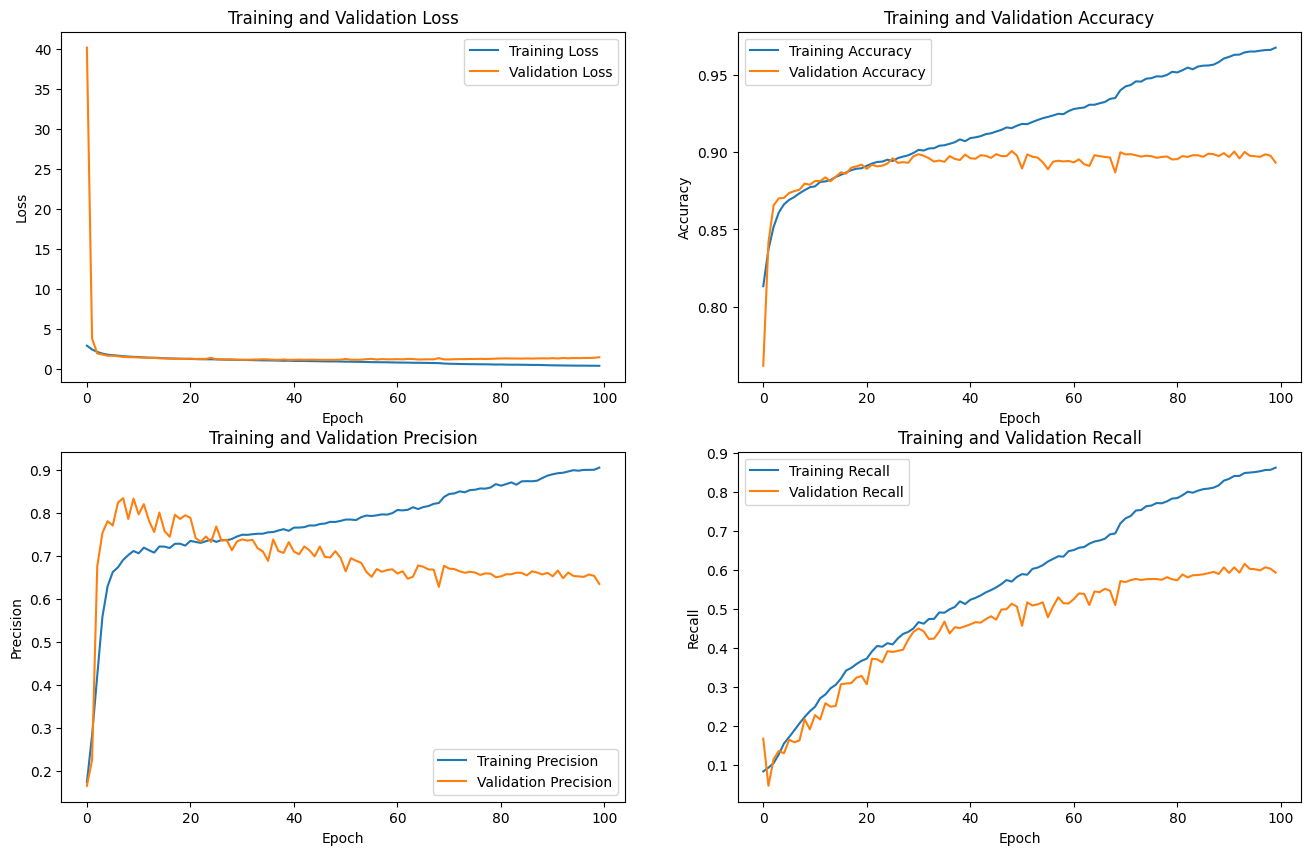

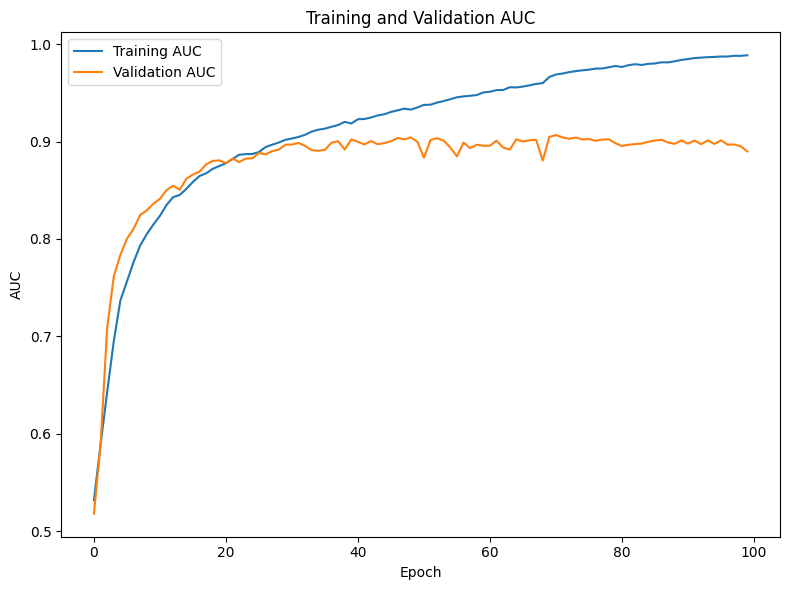

In [13]:
training_loss = history_resnet.history['loss']
validation_loss = history_resnet.history['val_loss']
training_accuracy = history_resnet.history['accuracy']
validation_accuracy = history_resnet.history['val_accuracy']
training_precision = history_resnet.history['precision']
validation_precision = history_resnet.history['val_precision']
training_recall = history_resnet.history['recall']
validation_recall = history_resnet.history['val_recall']
training_auc = history_resnet.history['auc']
validation_auc = history_resnet.history['val_auc']

# Plotting the loss and accuracy
plt.figure(figsize=(16, 10))

plt.subplot(2, 2, 1)
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plotting the precision
plt.subplot(2, 2, 3)
plt.plot(training_precision, label='Training Precision')
plt.plot(validation_precision, label='Validation Precision')
plt.title('Training and Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.legend()

# Plotting the recall
plt.subplot(2, 2, 4)
plt.plot(training_recall, label='Training Recall')
plt.plot(validation_recall, label='Validation Recall')
plt.title('Training and Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.legend()

# Plotting the AUC
plt.figure(figsize=(8, 6))
plt.plot(training_auc, label='Training AUC')
plt.plot(validation_auc, label='Validation AUC')
plt.title('Training and Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()

# **Evaluation The ResNet50 Model**

  1/113 ━━━━━━━━━━━━━━━━━━━━ 7:06 4s/step

W0000 00:00:1719486188.297428     130 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


113/113 ━━━━━━━━━━━━━━━━━━━━ 57s 476ms/step


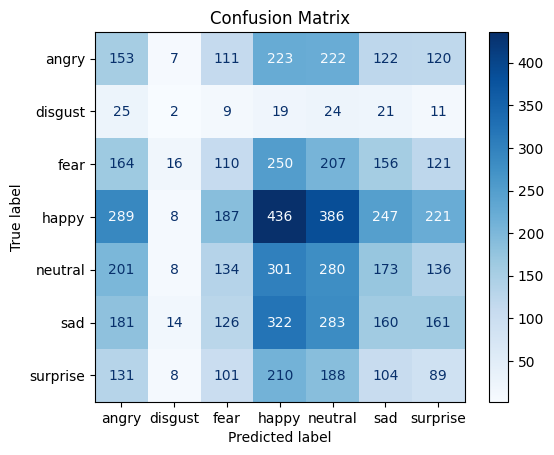

In [14]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
test_data.reset()  
predictions = model_resnet.predict(test_data)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_data.classes


cm = confusion_matrix(true_classes, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_data.class_indices.keys())
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

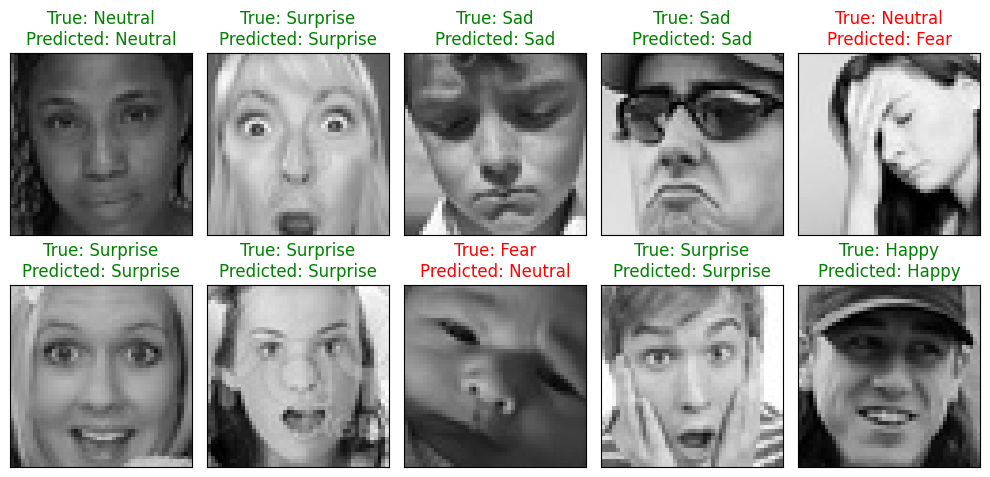

In [15]:
Emotion_Classes = ['Angry', 'Disgust', 'Fear', 'Happy', 'Neutral', 'Sad', 'Surprise']

# Assuming test_generator and model are already defined
batch_size = test_data.batch_size

# Selecting a random batch from the test generator
Random_batch = np.random.randint(0, len(test_data) - 1)

# Selecting random image indices from the batch
Random_Img_Index = np.random.randint(0, batch_size, 10)

# Setting up the plot
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    # Fetching the random image and its label
    Random_Img = test_data[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_data[Random_batch][1][Random_Img_Index[i]], axis=0)

    # Making a prediction using the model
    Model_Prediction = np.argmax(model_resnet.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    # Displaying the image
    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()